<a href="https://colab.research.google.com/github/armangupta910/Movie-Recommendor-System/blob/main/Collaborative_using_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

## Loading MovieLens dataset

In [100]:

column_names1 = ['userId','movieId','rating','timestamp']
dataset = pd.read_csv("https://raw.githubusercontent.com/armangupta910/Movie-Recommendor-System/main/dataSet/ratings.csv")
dataset.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [101]:
len(dataset), max(dataset['movieId']),min(dataset['movieId'])

(100836, 193609, 1)

In [102]:
movies = pd.read_csv('https://raw.githubusercontent.com/armangupta910/Movie-Recommendor-System/main/dataSet/movies.csv')

movie_dataset = movies[['movieId','title']]
movie_dataset.head()



,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


## Merging required datasets

In [103]:
merged_dataset = pd.merge(dataset, movie_dataset, how='inner', on='movieId')
merged_dataset.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


A dataset is created from the existing merged dataset by grouping the unique user id and movie title combination and the ratings by a user to the same movie in different instances (timestamps) are averaged and stored in the new dataset.

Example of a multiple rating scenario by an user to a specific movie:

In [104]:
merged_dataset[(merged_dataset['title'] == 'Chasing Amy (1997)') & (merged_dataset['userId'] == 894)]

,userId,movieId,rating,timestamp,title


In [105]:
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0


## Exploratory data analysis

*   Plot the counts of each rating
*   Plot rating frequency of each movie

**Plot the counts of each rating**

we first need to get the counts of each rating from ratings data

In [106]:

num_users = len(refined_dataset['userId'].value_counts())
num_items = len(refined_dataset['title'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))
print('Unique number of movies in the dataset: {}'.format(num_items))


Unique number of users in the dataset: 610
Unique number of movies in the dataset: 9719


In [107]:
rating_count_df = pd.DataFrame(refined_dataset.groupby(['rating']).size(), columns=['count'])
rating_count_df

,count
rating,
0.50,1370
1.00,2811
1.50,1791
2.00,7550
2.25,1
2.50,5549
3.00,20047
3.50,13134
4.00,26817


Text(0, 0.5, 'number of ratings')

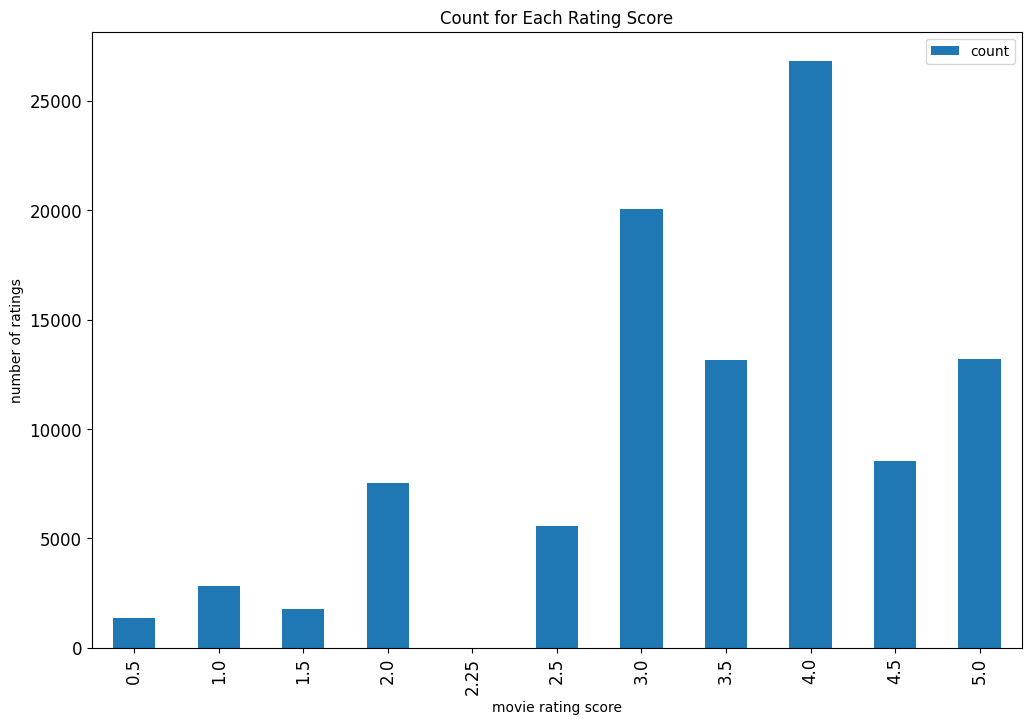

In [108]:
ax = rating_count_df.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating Score',
    fontsize=12)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

We can see that number of 1.5, 2.5, 3.5, 4.5 ratings by the users are comparitively negligible.

Ratings for the movies not seen by a user is by default considered as 0. Lets calculate and add it to the existing dataframe.

In [109]:
total_count = num_items * num_users
zero_count = total_count-refined_dataset.shape[0]
zero_count

5827758

In [110]:

import pandas as pd

# Append using pd.concat instead of DataFrame.append
rating_count_df = pd.concat(
    [rating_count_df, pd.DataFrame({'count': zero_count}, index=[0.0])],
    ignore_index=False
).sort_index()
print(rating_count_df)


        count
0.00  5827758
0.50     1370
1.00     2811
1.50     1791
2.00     7550
2.25        1
2.50     5549
3.00    20047
3.50    13134
4.00    26817
4.50     8551
5.00    13211


Number of times no rating was given (forged as 0 in this case) is a lot more than other ratings.

So let's take log transform for count values and then we can plot them to compare

In [111]:
# add log count
rating_count_df['log_count'] = np.log(rating_count_df['count'])
rating_count_df

,count,log_count
0.00,5827758,15.578143
0.50,1370,7.222566
1.00,2811,7.941296
1.50,1791,7.490529
2.00,7550,8.929303
2.25,1,0.000000
2.50,5549,8.621373
3.00,20047,9.905835
3.50,13134,9.482960
4.00,26817,10.196791


In [112]:
rating_count_df = rating_count_df.reset_index().rename(columns={'index': 'rating score'})
rating_count_df

,rating score,count,log_count
0,0.00,5827758,15.578143
1,0.50,1370,7.222566
2,1.00,2811,7.941296
3,1.50,1791,7.490529
4,2.00,7550,8.929303
5,2.25,1,0.000000
6,2.50,5549,8.621373
7,3.00,20047,9.905835
8,3.50,13134,9.482960
9,4.00,26817,10.196791


Text(0, 0.5, 'number of ratings')

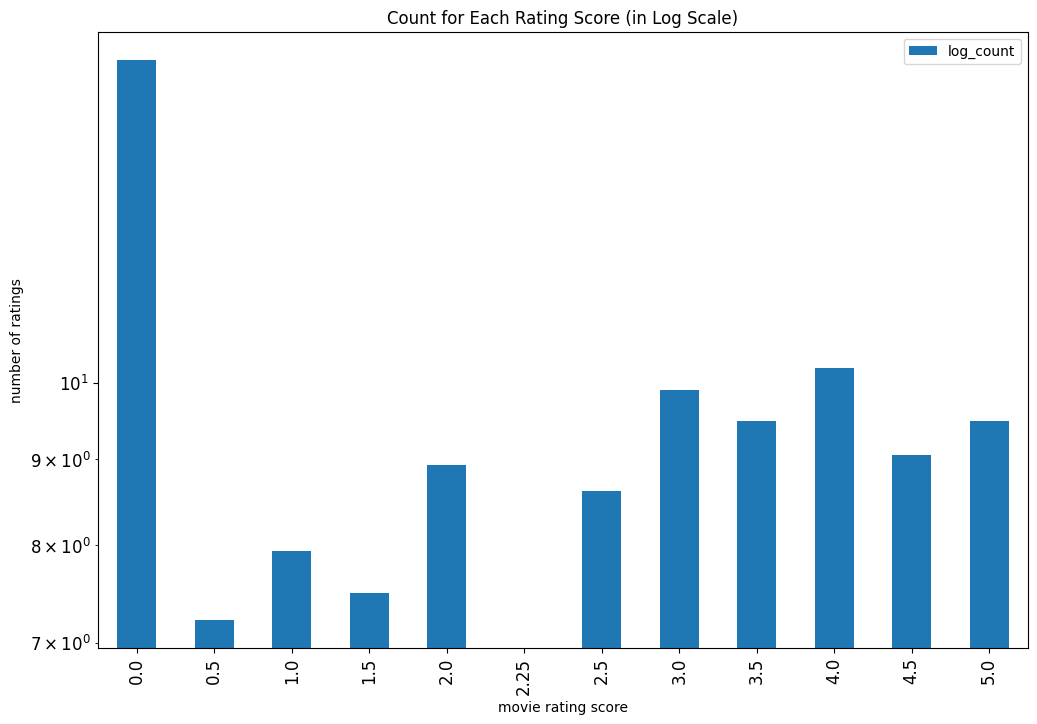

In [113]:
ax = rating_count_df.plot('rating score', 'log_count', 'bar', figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,)

ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

We have already observed from the before bar plot that ratings 3 and 4 are given in more numbers by the users. Even the above graph suggests the same.

 Take away from this plot is by the number of missing ratings, we can estimate the level of sparsity in the matrix we are going to form.

**Plot rating frequency of all movies**

In [114]:
refined_dataset.head()

,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0


In [115]:
# get rating frequency
movies_count_df = pd.DataFrame(refined_dataset.groupby('title').size(), columns=['count'])
movies_count_df.head()

,count
title,
'71 (2014),1
'Hellboy': The Seeds of Creation (2004),1
'Round Midnight (1986),2
'Salem's Lot (2004),1
'Til There Was You (1997),2


Text(0, 0.5, 'number of ratings')

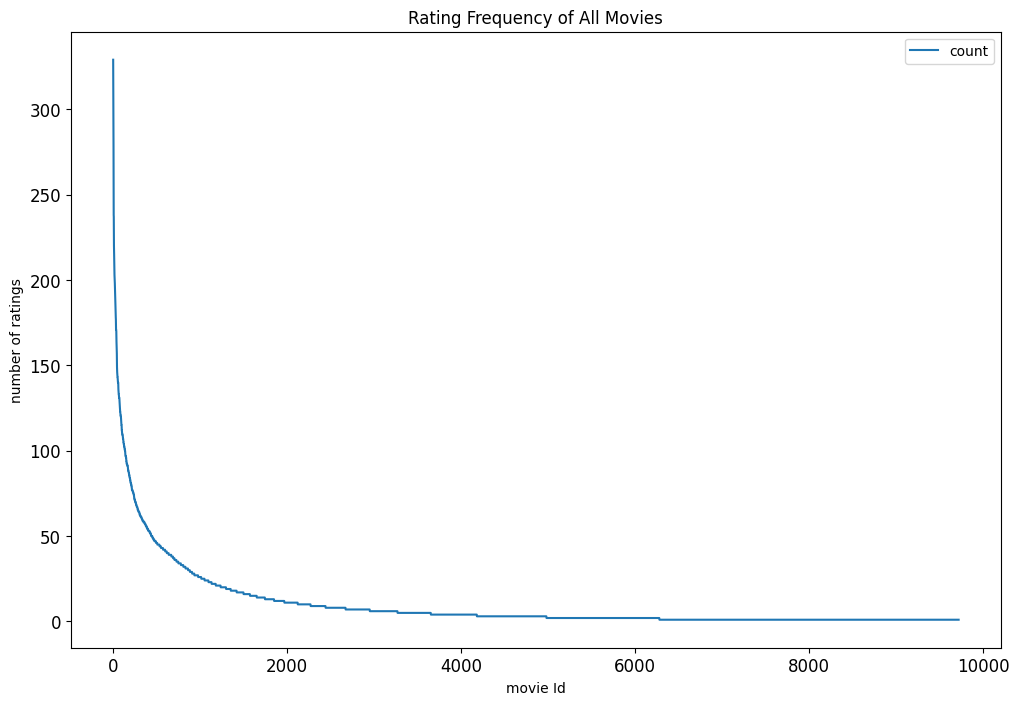

In [116]:
# plot rating frequency of all movies
ax = movies_count_df \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

**As the size of MovieLens dataset picked for this project is small. There is no need of removing rarely rated movies or users who has given rating for fewer movies.**

**Also because the dataset considered is small, we do not see the long-tail property which will be the scenario with the distribution of ratings.**

*If the dataset is larger, then* (this can be referred when we do similar kind of tasks with a larger dataset, just for future reference)

The distribution of ratings among movies often satisfies a property in real-world settings, which is referred to as the long-tail property. According to this property, only a small fraction of the items are rated frequently. Such items are referred to as popular items. The vast majority of items are rated rarely. This results in a highly skewed distribution of the underlying ratings.

# Training KNN model to build item-based collaborative Recommender System.

**Reshaping the dataframe**

We need to transform (reshape in this case) the data in such a way that each row of the dataframe represents a movie and each column represents a different user. So we want the data to be [movies, users] array if movie is the subject where similar movies must be found and [users, movies] array for reverse.

To reshape the dataframe, we will pivot the dataframe to the wide format with movies as rows and users as columns. As we know that not all users watch all the movies, we can expect a lot of missing values. We will have to fill those missing observations with 0s since we are going to perform linear algebra operations (calculating distances between vectors).

Finally, we transform the values of the dataframe into a scipy sparse matrix for most efficient calculations.

This dataframe is then fed into a KNN model.

## Movie Recommendation using KNN with Input as **User id**, Number of similar users should the model pick and Number of movies you want to get recommended:

1. Reshaping model in such a way that each user has n-dimensional rating space where n is total number of movies

 We will train the KNN model inorder to find the closely matching similar users to the user we give as input and we recommend the top movies which would interest the input user.

In [117]:
# pivot and create movie-user matrix
user_to_movie_df = refined_dataset.pivot(
    index='userId',
     columns='title',
      values='rating').fillna(0)

user_to_movie_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
# transform matrix to scipy sparse matrix
user_to_movie_sparse_df = csr_matrix(user_to_movie_df.values)
user_to_movie_sparse_df

<610x9719 sparse matrix of type '<class 'numpy.float64'>'
	with 100832 stored elements in Compressed Sparse Row format>

**Fitting K-Nearest Neighbours model to the scipy sparse matrix:**

In [119]:
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(user_to_movie_sparse_df)

NearestNeighbors(algorithm='brute', metric='cosine')

In [120]:
## function to find top n similar users of the given input user
def get_similar_users(user, n = 5):
  ## input to this function is the user and number of top similar users you want.

  knn_input = np.asarray([user_to_movie_df.values[user-1]])  #.reshape(1,-1)
  # knn_input = user_to_movie_df.iloc[0,:].values.reshape(1,-1)
  distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)

  print("Top",n,"users who are very much similar to the User-",user, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
  return indices.flatten()[1:] + 1, distances.flatten()[1:]


**Specify User id and Number of similar users we want to consider here**

In [121]:
from pprint import pprint
user_id = 500
print(" Few of movies seen by the User:")
pprint(list(refined_dataset[refined_dataset['userId'] == user_id]['title'])[:10])
similar_user_list, distance_list = get_similar_users(user_id,5)

 Few of movies seen by the User:
['10 Things I Hate About You (1999)',
 'Akira (1988)',
 'Aladdin (1992)',
 'All About My Mother (Todo sobre mi madre) (1999)',
 'American Beauty (1999)',
 'American Pie (1999)',
 'American President, The (1995)',
 'Analyze This (1999)',
 'Antz (1998)',
 'Army of Darkness (1993)']
Top 5 users who are very much similar to the User- 500 are: 
 
1 . User: 453 separated by distance of 0.7201678594706974
2 . User: 45 separated by distance of 0.7376312502566356
3 . User: 57 separated by distance of 0.756338436627164
4 . User: 597 separated by distance of 0.7814852399049113
5 . User: 19 separated by distance of 0.7891282989026649


**With the help of the KNN model built, we could get desired number of top similar users.**

**Now we will have to pick the top movies to recommend.**

**One way would be by taking the average of the existing ratings given by the similar users and picking the top 10 or 15 movies to recommend to our current user.**

**But I feel recommendation would be more effective if we define weights to ratings by each similar user based on the thier distance from the input user. Defining these weights would give us the accurate recommendations by eliminating the chance of decision manipulation by the users who are relatively very far from the input user.**

In [122]:
similar_user_list, distance_list

(array([453,  45,  57, 597,  19]),
 array([0.72016786, 0.73763125, 0.75633844, 0.78148524, 0.7891283 ]))

In [123]:
weightage_list = distance_list/np.sum(distance_list)
weightage_list

array([0.19028143, 0.19489558, 0.19983836, 0.2064826 , 0.20850203])

Getting ratings of all movies by derived similar users

In [124]:
mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
mov_rtngs_sim_users

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [125]:
movies_list = user_to_movie_df.columns
movies_list

Index([''71 (2014)', ''Hellboy': The Seeds of Creation (2004)',
       ''Round Midnight (1986)', ''Salem's Lot (2004)',
       ''Til There Was You (1997)', ''Tis the Season for Love (2015)',
       ''burbs, The (1989)', ''night Mother (1986)',
       '(500) Days of Summer (2009)', '*batteries not included (1987)',
       ...
       'Zulu (2013)', '[REC] (2007)', '[REC]² (2009)',
       '[REC]³ 3 Génesis (2012)',
       'anohana: The Flower We Saw That Day - The Movie (2013)',
       'eXistenZ (1999)', 'xXx (2002)', 'xXx: State of the Union (2005)',
       '¡Three Amigos! (1986)', 'À nous la liberté (Freedom for Us) (1931)'],
      dtype='object', name='title', length=9719)

In [126]:
print("Weightage list shape:", len(weightage_list))
print("mov_rtngs_sim_users shape:", mov_rtngs_sim_users.shape)
print("Number of movies:", len(movies_list))

Weightage list shape: 5
mov_rtngs_sim_users shape: (5, 9719)
Number of movies: 9719


**Broadcasting weightage matrix to similar user rating matrix. so that it gets compatible for matrix operations**

In [127]:
weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
weightage_list.shape

(5, 9719)

In [128]:
new_rating_matrix = weightage_list*mov_rtngs_sim_users
mean_rating_list = new_rating_matrix.sum(axis =0)
mean_rating_list

array([0., 0., 0., ..., 0., 0., 0.])

In [129]:
from pprint import pprint
def recommend_movies(n):
  n = min(len(mean_rating_list),n)
  # print(np.argsort(mean_rating_list)[::-1][:n])
  pprint(list(movies_list[np.argsort(mean_rating_list)[::-1][:n]]))



In [130]:
print("Movies recommended based on similar users are: ")
recommend_movies(10)

Movies recommended based on similar users are: 
['Beauty and the Beast (1991)',
 'Aladdin (1992)',
 'Lion King, The (1994)',
 'Snow White and the Seven Dwarfs (1937)',
 'Willy Wonka & the Chocolate Factory (1971)',
 'Nightmare Before Christmas, The (1993)',
 'Fugitive, The (1993)',
 'Braveheart (1995)',
 'While You Were Sleeping (1995)',
 'Usual Suspects, The (1995)']


It had been observed that, this recommendation system built can be made more efficient as it has few drawbacks.

**Drawbacks:**

**1.** But this recommendation system has a drawback, it also **recommends movies which are already seen by the given input User.**

**2.** And also there is a possibility of recommending the **movies which are not at all seen by any of the similar users.**

**Above drawbacks are addressed and a new recommender system with modification is built**

Below function is defined to remove the movies which are already seen the current user and not at all seen by any of the similar users.

In [131]:

def filtered_movie_recommendations(n):

  first_zero_index = np.where(mean_rating_list == 0)[0][-1]
  sortd_index = np.argsort(mean_rating_list)[::-1]
  sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
  n = min(len(sortd_index),n)
  movies_watched = list(refined_dataset[refined_dataset['userId'] == user_id]['title'])
  filtered_movie_list = list(movies_list[sortd_index])
  count = 0
  final_movie_list = []
  for i in filtered_movie_list:
    if i not in movies_watched:
      count+=1
      final_movie_list.append(i)
    if count == n:
      break
  if count == 0:
    print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
  else:
    pprint(final_movie_list)


In [132]:
filtered_movie_recommendations(10)

['Willy Wonka & the Chocolate Factory (1971)',
 'Nightmare Before Christmas, The (1993)',
 'Fugitive, The (1993)',
 'Braveheart (1995)',
 'While You Were Sleeping (1995)',
 'Usual Suspects, The (1995)',
 'Harry Potter and the Chamber of Secrets (2002)',
 'Jungle Book, The (1994)',
 'Shawshank Redemption, The (1994)',
 'Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']


Coding up all of the above individual cells into a function.

Giving Input as **User id, Number of similar Users to be considered, Number of top movie we want to recommend**

In [133]:
from pprint import pprint

def recommender_system(user_id, n_similar_users, n_movies): #, user_to_movie_df, knn_model):

  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['userId'] == user_id]['title']))
  print("")

  # def get_similar_users(user, user_to_movie_df, knn_model, n = 5):
  def get_similar_users(user, n = 5):

    knn_input = np.asarray([user_to_movie_df.values[user-1]])

    distances, indices = knn_model.kneighbors(knn_input, n_neighbors=n+1)

    print("Top",n,"users who are very much similar to the User-",user, "are: ")
    print(" ")

    for i in range(1,len(distances[0])):
      print(i,". User:", indices[0][i]+1, "separated by distance of",distances[0][i])
    print("")
    return indices.flatten()[1:] + 1, distances.flatten()[1:]


  def filtered_movie_recommendations(n = 10):

    first_zero_index = np.where(mean_rating_list == 0)[0][-1]
    sortd_index = np.argsort(mean_rating_list)[::-1]
    sortd_index = sortd_index[:list(sortd_index).index(first_zero_index)]
    n = min(len(sortd_index),n)
    movies_watched = list(refined_dataset[refined_dataset['userId'] == user_id]['title'])
    filtered_movie_list = list(movies_list[sortd_index])
    count = 0
    final_movie_list = []
    for i in filtered_movie_list:
      if i not in movies_watched:
        count+=1
        final_movie_list.append(i)
      if count == n:
        break
    if count == 0:
      print("There are no movies left which are not seen by the input users and seen by similar users. May be increasing the number of similar users who are to be considered may give a chance of suggesting an unseen good movie.")
    else:
      pprint(final_movie_list)

  similar_user_list, distance_list = get_similar_users(user_id,n_similar_users)
  weightage_list = distance_list/np.sum(distance_list)
  mov_rtngs_sim_users = user_to_movie_df.values[similar_user_list]
  movies_list = user_to_movie_df.columns
  weightage_list = weightage_list[:,np.newaxis] + np.zeros(len(movies_list))
  new_rating_matrix = weightage_list*mov_rtngs_sim_users
  mean_rating_list = new_rating_matrix.sum(axis =0)
  print("")
  print("Movies recommended based on similar users are: ")
  print("")
  filtered_movie_recommendations(n_movies)

In [134]:
print("Enter user id")
user_id= int(input())
print("number of similar users to be considered")
sim_users = int(input())
print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,sim_users,n_movies)
# recommender_system(300, 15,15)

Enter user id
100
number of similar users to be considered
5
Enter number of movies to be recommended:
10
Movie seen by the User:
['12 Angry Men (1957)',
 '8 Mile (2002)',
 'About Last Night... (1986)',
 'Ace Ventura: When Nature Calls (1995)',
 'Affair to Remember, An (1957)',
 'Amadeus (1984)',
 'American History X (1998)',
 'American Pie (1999)',
 'American President, The (1995)',
 'American in Paris, An (1951)',
 'Analyze This (1999)',
 'As Good as It Gets (1997)',
 'Austin Powers: International Man of Mystery (1997)',
 'Austin Powers: The Spy Who Shagged Me (1999)',
 'Back to the Future (1985)',
 'Batman (1989)',
 'Beautiful Mind, A (2001)',
 'Bed of Roses (1996)',
 'Benny & Joon (1993)',
 'Best in Show (2000)',
 'Better Off Dead... (1985)',
 "Bill & Ted's Excellent Adventure (1989)",
 'Blair Witch Project, The (1999)',
 'Blast from the Past (1999)',
 'Blues Brothers, The (1980)',
 'Breakfast Club, The (1985)',
 "Bridget Jones's Diary (2001)",
 'Broken Arrow (1996)',
 'Casino (199

## Movie Recommendation using KNN with Input as **Movie Name** and Number of movies you want to get recommended:

2. Reshaping model in such a way that each movie has n-dimensional rating space where n is total number of users who could rate.

 We will train the KNN model inorder to find the closely matching similar movies to the movie we give as input and we recommend the top movies which would more closely align to the movie we have given.

In [135]:
# pivot and create movie-user matrix
movie_to_user_df = refined_dataset.pivot(
     index='title',
   columns='userId',
      values='rating').fillna(0)

movie_to_user_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
# transform matrix to scipy sparse matrix
movie_to_user_sparse_df = csr_matrix(movie_to_user_df.values)
movie_to_user_sparse_df

<9719x610 sparse matrix of type '<class 'numpy.float64'>'
	with 100832 stored elements in Compressed Sparse Row format>

Extracting movie names into a list:

In [137]:
movies_list = list(movie_to_user_df.index)
movies_list[:10]

["'71 (2014)",
 "'Hellboy': The Seeds of Creation (2004)",
 "'Round Midnight (1986)",
 "'Salem's Lot (2004)",
 "'Til There Was You (1997)",
 "'Tis the Season for Love (2015)",
 "'burbs, The (1989)",
 "'night Mother (1986)",
 '(500) Days of Summer (2009)',
 '*batteries not included (1987)']

Creating a dictionary with movie name as key and its index from the list as value:

In [138]:
movie_dict = {movie : index for index, movie in enumerate(movies_list)}
# print(movie_dict)

In [139]:
case_insensitive_movies_list = [i.lower() for i in movies_list]

Fitting a KNN model:

In [140]:
knn_movie_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_movie_model.fit(movie_to_user_sparse_df)


NearestNeighbors(algorithm='brute', metric='cosine')

In [141]:
## function to find top n similar users of the given input user
def get_similar_movies(movie, n = 10):
  ## input to this function is the movie and number of top similar movies you want.
  index = movie_dict[movie]
  knn_input = np.asarray([movie_to_user_df.values[index]])
  n = min(len(movies_list)-1,n)
  distances, indices = knn_movie_model.kneighbors(knn_input, n_neighbors=n+1)

  print("Top",n,"movies which are very much similar to the Movie-",movie, "are: ")
  print(" ")
  for i in range(1,len(distances[0])):
    print(movies_list[indices[0][i]])



Testing the recommender system with basic input with the movie names


In [142]:
from pprint import pprint
movie_name = '101 Dalmatians (1996)'

get_similar_movies(movie_name,15)

Top 15 movies which are very much similar to the Movie- 101 Dalmatians (1996) are: 
 
Matilda (1996)
Jack (1996)
Dumbo (1941)
George of the Jungle (1997)
Hunchback of Notre Dame, The (1996)
Space Jam (1996)
Peter Pan (1953)
Willy Wonka & the Chocolate Factory (1971)
James and the Giant Peach (1996)
How the Grinch Stole Christmas (a.k.a. The Grinch) (2000)
Mary Poppins (1964)
Dracula: Dead and Loving It (1995)
Alice in Wonderland (1951)
Mars Attacks! (1996)
Toy Story (1995)


### Rough Unused

**Dynamically suggesting** movie name from the existing movie corpus we have, based on the user input using try and except architecture.

Defining a function which outputs movie names as suggestion when the user mis spells the movie name. **User might have intended to type any of these movie names.**

In [143]:
# function which takes input and returns suggestions for the user

def get_possible_movies(movie):

    temp = ''
    possible_movies = case_insensitive_movies_list.copy()
    for i in movie :
      out = []
      temp += i
      for j in possible_movies:
        if temp in j:
          out.append(j)
      if len(out) == 0:
          return possible_movies
      out.sort()
      possible_movies = out.copy()

    return possible_movies

This function provides user with **movie name suggestions if movie name is mis-spelled** or **Recommends similar movies to the input movie** if the movie name is valid.

In [144]:
class invalid(Exception):
    pass

def spell_correction():

      movie_name = input("Enter the Movie name: ")
      movie_name_lower = movie_name.lower()
      num_recom = int(input("Enter Number of movie recommendations needed: "))
      # get_similar_movies(movies_list[case_insensitive_movies_list.index(get_possible_movies(movie_name_lower))],num_recom)

      if(movie_name not in movies_list):
        get_similar_movies(get_possible_movies(movie_name_lower))

      else:
        get_similar_movies(movie_name)


      # possible_movies = get_possible_movies(movie_name_lower)

      # if len(possible_movies) == len(movies_list) :
      #   print("Movie name entered is does not exist in the list ")
      # else :
      #   indices = [case_insensitive_movies_list.index(i) for i in possible_movies]
      #   print("Entered Movie name is not matching with any movie from the dataset . Please check the below suggestions :\n",[movies_list[i] for i in indices])
      #   spell_correction()


In [145]:
# # calcuate total number of entries in the movie-user matrix
# num_entries = movie_to_user_df.shape[0] * movie_to_user_df.shape[1]
# # calculate total number of entries with zero values
# num_zeros = (movie_to_user_df==0).sum(axis=1).sum()
# # calculate ratio of number of zeros to number of entries
# ratio_zeros = num_zeros / num_entries
# print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))